# ノンパラメトリック密度推定

2つの正規分布からなる混合分布があるとする

$$
0.3 \mathcal{N}(0.25, 0.01)
+ 0.7 \mathcal{N}(0.75, 0.01)
$$

確率密度関数は下の図の左側のようになる。

この分布から100個のサンプルが得られたとする。ヒストグラムは右側の図のようになる。

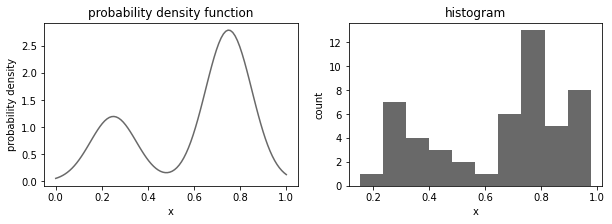

In [240]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# gen data
# 2つの正規分布の混合分布
w = 0.3
params = [dict(loc=0.25, scale=0.1), dict(loc=0.75, scale=0.1)]

def pdf(x):
    return w * norm.pdf(x, **params[0]) + (1 - w) * norm.pdf(x, **params[1])


def rvs(size):
    n = int(w * size)
    return np.append(norm.rvs(size=n, random_state=0, **params[0]), norm.rvs(size=(size - n), random_state=0, **params[1]))


fig, axes = plt.subplots(figsize=[10, 3], ncols=2)
axes[0].set(xlabel="x", ylabel="probability density", title="probability density function")
x_range = np.linspace(0, 1, 100)
axes[0].plot(x_range, [pdf(xi) for xi in x_range], color="dimgray")

axes[1].set(xlabel="x", ylabel="count", title="histogram")
n = 50
x = rvs(n)
x = np.sort(x)
axes[1].hist(x, color="dimgray")
fig.show()

## ヒストグラム密度推定法

**ヒストグラム密度推定法**（histogram density estimation method）

1つの連続変数$x$が対象の場合を考える。

標準的なヒストグラムでは、$x$を幅$\Delta_i$の区間に区切り、$i$番目の区間に入った$x$の観測値の数$n_i$と観測値の総数$N$を用いて、各区間の確率密度を

$$
p_i = \frac{n_i}{N \Delta_i}
$$

で推定する。

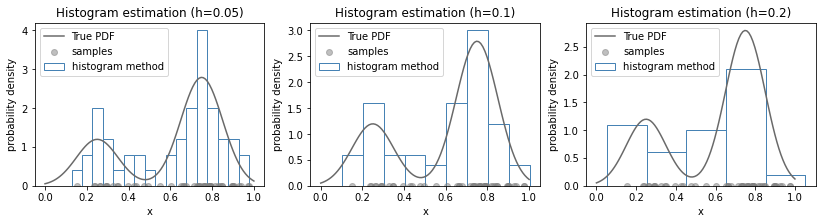

In [305]:
class HistogramEstimator:

    def __init__(self, bandwidth: float):
        self.h = bandwidth

    def fit(self, x: np.array):
        # calc bins
        range_ = max(x) - min(x)
        times = int(np.ceil(range_ / self.h))
        bins = [min(x) + self.h * i for i in range(times + 1)]
        # calc probabilities
        N = x.shape[0]
        probs = []
        deltas = []
        for i in range(1, len(bins)):
            values = x[(bins[i - 1] <= x) & (x < bins[i])]
            n = len(values)
            delta = bins[i] - bins[i - 1]
            p = n / (N * delta)
            probs.append(p)
            deltas.append((bins[i - 1], bins[i]))
        self.probs_ = probs
        self.deltas_ = deltas
        return self

    def predict(self, x: np.array) -> np.array:
        p_pred = np.zeros(shape=x.shape[0])
        for (lower, upper), p in zip(self.deltas_, self.probs_):
            p_pred[(lower <= x) & (x < upper)] = p
        return p_pred

# plot
fig, axes = plt.subplots(figsize=[14, 3], ncols=3)

for ax, h in zip(axes, [0.05, 0.10, 0.2]):
    # true
    x_range = np.linspace(0, 1, 100)
    ax.plot(x_range, [pdf(xi) for xi in x_range], color="dimgray", label="True PDF")

    # estimates
    estimator = HistogramEstimator(bandwidth=h)
    estimator.fit(x)
    for (lower, upper), p in zip(estimator.deltas_, estimator.probs_):
        ax.bar(lower, p, h, color="white", edgecolor="steelblue")
        
    ax.bar(lower, p, h, color="white", edgecolor="steelblue", label="histogram method")

    ax.scatter(x, np.zeros(x.shape[0]), label="samples", color="gray", alpha=0.5)
    ax.set(xlabel="x", ylabel="probability density", title=f"Histogram estimation (h={h})")
    ax.legend()

fig.show()

この方法の結果の良し悪しは区間幅$\Delta_i$に大きく依存する。幅が狭すぎても区間に含まれるサンプルが少なすぎて推定のばらつきが大きくなるし、幅が広すぎても表現力が不足して分布をうまく捉えられなくなる。

また、ヒストグラム法の問題として

1. 推定した密度が区間の縁で不連続になる
2. 次元の呪いに弱い：次元数を上げていった場合、$D$次元空間を各変数につき$M$個の区間にすると、区間の総数は$M^D$個になり、各区間に含まれるデータ量が不足する

といったものがある

## カーネル密度推定法

$D$次元のユークリッド空間中の未知の確率密度$p(\boldsymbol{x})$から観測値の集合が得られていて、この集合から$p(\boldsymbol{x})$の値を推定したいとする。

$\boldsymbol{x}$を含むある小さな領域$\mathcal{R}$を考える。

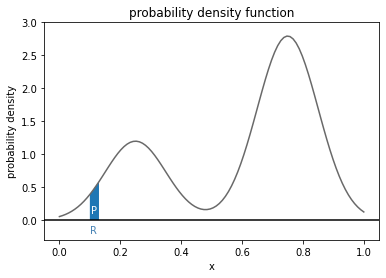

In [384]:
fig, ax = plt.subplots()
ax.plot(x_range, [pdf(xi) for xi in x_range], color="dimgray")
ax.fill_between(x=(0.1, 0.13), y1=(0, 0), y2=(pdf(0.1), pdf(0.13)))
ax.text(0.105, 0.1, "P", color="white")
ax.text(0.1, -0.2, "R", color="steelblue")
ax.axhline(0, color="black")
ax.set(ylim=(-0.3, 3), xlabel="x", ylabel="probability density", title="probability density function")
fig.show()

from myst_nb import glue
glue("func_fig", fig, display=False)

```{margin}
領域のイメージ
{glue:}`func_fig`
```

この領域に割り当てられた確率は

$$
P = \int_{\mathcal{R}} p(\boldsymbol{x}) d\boldsymbol{x}
$$

と表せる。

ここで$p(\boldsymbol{x})$から得られた$N$個の観測値からなるデータ集合があるとする。各データ店が領域$\mathcal{R}$中にある確率は$P$なので、$\mathcal{R}$内の点の総数$K$は二項分布に従う

$$
Bin(K|N, P) = \frac{N!}{K!(N-K)!} P^K (1-P)^{N-K}
$$


よって、データ点がこの領域内にある平均割合と分散は

$$
E[K/N] = P,
\hspace{2em}
Var[K/N] = \frac{P(1-P)}{N}
$$

となる。

大きい$N$については、分散が小さくなって平均の周囲で鋭く尖った分布となり、

$$
K \simeq NP
$$

となる。

$\mathcal{R}$が確率密度$p(\boldsymbol{x})$がこの領域内でほぼ一定とみなせるほど十分に小さいものであると仮定できるのであれば、領域の体積$V$を用いて

$$
P \simeq p(\boldsymbol{x}) V
$$

となる。

これらを組み合わせて、次の密度の推定量が得られる。

$$
p(\boldsymbol{x}) = \frac{K}{NV}
$$

:::{note}
上記の推定量の正しさは、2つの相反する仮定に基づく

1. 領域内では密度が一定とみなせるほど十分に領域$\mathcal{R}$は小さい
2. 領域内のデータ点$K$が二項分布が尖るほどに多く存在している
:::


### カーネル関数

確率密度を求めたいデータ点$\boldsymbol{x}$を中心とする小さな超立方体を領域$\mathcal{R}$とする。
この領域内にある点の数$K$を数えるには、次の関数を定義しておくと便利である。

$$
k(\boldsymbol{u}) =
\begin{cases}
  1, & |u_i| \leq \frac{1}{2}, & \text{ if } i=1,\cdots, D\\
  0, & \text{otherwise}
\end{cases}
$$

これは原点を中心とする単位立方体を表す。
関数$k(\boldsymbol{u})$は**カーネル関数**（kernel function）のひとつであり、今回の用途では**Parzen窓**（parzen window）とも呼ばれる。

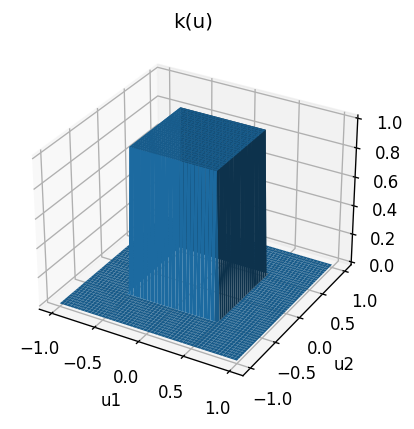

In [219]:
def k(u):
    return 1 * all([abs(ui) <= (1/2) for ui in u])

u1 = np.linspace(-1, 1, 51)
u2 = np.linspace(-1, 1, 51)
u1, u2 = np.meshgrid(u1, u2)
k_ = np.array([k([_u1, _u2]) for _u1, _u2 in zip(u1.flatten(), u2.flatten())]).reshape(u1.shape)

fig, ax = plt.subplots(dpi=120, subplot_kw={"projection": "3d"})
ax.plot_surface(u1, u2, k_, rstride=1, cstride=1, linewidth=1, antialiased=True)
ax.set(xlabel="u1", ylabel="u2", zlabel="k", title="k(u)")
fig.show()

$k((\boldsymbol{x} - \boldsymbol{x}_n)/h)$は$\boldsymbol{x}$を中心とする一辺が$h$の立方体の内部に、データ点$\boldsymbol{x}_n$があれば1に、そうでなければ0となる。

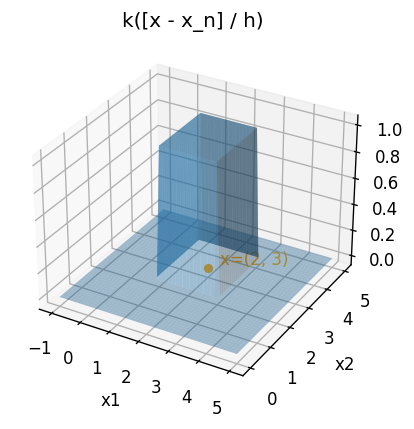

In [224]:
_x = np.array([2, 3])
h = 2

x1 = np.linspace(-1, 5, 51)
x2 = np.linspace(0, 5, 51)
x1, x2 = np.meshgrid(x1, x2)
k_ = np.array([k( ( _x - np.array([_x1, _x2]) ) / h )
               for _x1, _x2 in zip(x1.flatten(), x2.flatten())]).reshape(u1.shape)

fig, ax = plt.subplots(dpi=120, subplot_kw={"projection": "3d"})

ax.scatter(_x[0], _x[1], color="orange")
ax.text(_x[0] * 1.1, _x[1] * 1.1, 0, f"x=({_x[0]}, {_x[1]})", color="orange")

ax.plot_surface(x1, x2, k_, rstride=1, cstride=1, linewidth=1, antialiased=True, alpha=0.4)
ax.set(xlabel="x1", ylabel="x2", zlabel="k", title="k([x - x_n] / h)")
fig.show()


よってこの立方体内部の総点数は

$$
K = \sum^N_{n=1}
k \left( \frac{\boldsymbol{x} - \boldsymbol{x}_n}{h} \right)
$$

となる。

さきほどの$p(\boldsymbol{x})$の推定量

$$
p(\boldsymbol{x}) = \frac{K}{NV}
$$

に代入すると

$$
p(\boldsymbol{x})
= \frac{1}{NV}
\sum^N_{n=1} k \left( \frac{\boldsymbol{x} - \boldsymbol{x}_n}{h} \right)
$$

一辺が$h$の$D$次元立方体の体積が$V=h^D$であることを用いると

$$
p(\boldsymbol{x})
= \frac{1}{N} \frac{1}{h^D} 
\sum^N_{n=1} k \left( \frac{\boldsymbol{x} - \boldsymbol{x}_n}{h} \right)
$$

となる。

このカーネルを使用した推定結果は次の図のようになる。
立方体を重ねるような推定を行うため平滑性がなく、ギザギザした密度関数が推定されている。

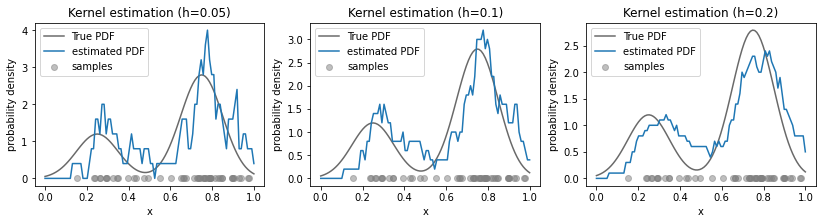

In [337]:
class KernelEstimator:

    def __init__(self, bandwidth: float):
        self.h = bandwidth

    def fit(self, X: np.array):
        self.X_train_ = X
        self.N_ = X.shape[0]
        self.D_ = X.shape[1]
        return self

    def predict(self, X: np.array) -> np.array:
        p_preds = []
        for x in X:
            U = (x - self.X_train_) / self.h
            K = [k(u) for u in U]
            p_pred = (1 / self.N_) * (1 / self.h ** self.D_) * np.sum( K )
            p_preds.append(p_pred)
        return np.array(p_preds)

# plot
fig, axes = plt.subplots(figsize=[14, 3], ncols=3)

for ax, h in zip(axes, [0.05, 0.10, 0.20]):
    # true
    x_range = np.linspace(0, 1, 100)
    ax.plot(x_range, [pdf(xi) for xi in x_range], color="dimgray", label="True PDF")

    # estimates
    X_train = x.reshape(-1, 1)
    X_test = x_range.reshape(-1, 1)

    estimator = KernelEstimator(bandwidth=h)
    estimator.fit(X_train)
    p = estimator.predict(X_test)
    ax.plot(x_range, p, label="estimated PDF")

    ax.scatter(x, np.zeros(x.shape[0]), label="samples", color="gray", alpha=0.5)
    ax.set(xlabel="x", ylabel="probability density", title=f"Kernel estimation (h={h})")
    ax.legend()

fig.show()

### ガウシアンカーネル

ガウス分布（正規分布）をカーネル関数に用いることで滑らかな密度推定を行う。

$$
p(\boldsymbol{x})
= \frac{1}{N}
\sum^N_{n=1} 
\frac{1}{(2 \pi h^2)^{D/2}}
\exp \left\{ -\frac{ ||\boldsymbol{x} - \boldsymbol{x}_n||^2 }{2 h^2} \right\}
$$



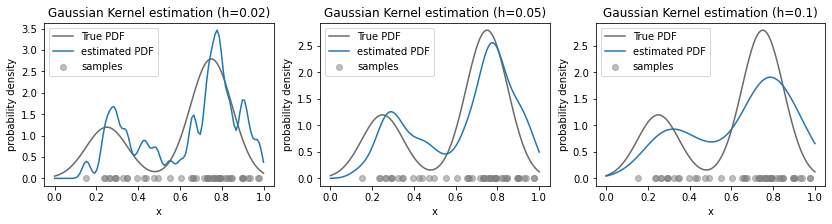

In [363]:
from scipy.stats import norm

class GaussianKernelEstimator:

    def __init__(self, bandwidth: float):
        self.h = bandwidth

    def fit(self, X: np.array):
        self.X_train_ = X
        self.N_ = X.shape[0]
        self.D_ = X.shape[1]
        return self

    def predict(self, X: np.array) -> np.array:
        p_preds = []
        for x in X:
            p_pred = norm.pdf(x=x, loc=self.X_train_, scale=self.h).mean()
            p_preds.append(p_pred)
        return np.array(p_preds)

# plot
fig, axes = plt.subplots(figsize=[14, 3], ncols=3)

for ax, h in zip(axes, [0.02, 0.05, 0.10]):
    # true
    x_range = np.linspace(0, 1, 100)
    ax.plot(x_range, [pdf(xi) for xi in x_range], color="dimgray", label="True PDF")

    # estimates
    X_train = x.reshape(-1, 1)
    X_test = x_range.reshape(-1, 1)

    estimator = GaussianKernelEstimator(bandwidth=h)
    estimator.fit(X_train)
    p = estimator.predict(X_test)
    ax.plot(x_range, p, label="estimated PDF")

    ax.scatter(x, np.zeros(x.shape[0]), label="samples", color="gray", alpha=0.5)
    ax.set(xlabel="x", ylabel="probability density", title=f"Gaussian Kernel estimation (h={h})")
    ax.legend()

fig.show()

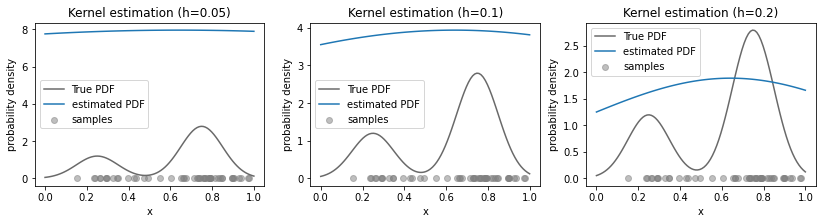

In [357]:
# 数式からガウスカーネルを実装したけど合わなかったやつ
def gauss(x, x_n, h, D):
    y = (1 / (2 * np.pi * h **2)**(D/2)) * np.exp(-(np.linalg.norm(x - x_n)**2 / 2 * h ** 2))
    return np.mean(y)

class GaussianKernelEstimator:

    def __init__(self, bandwidth: float):
        self.h = bandwidth

    def fit(self, X: np.array):
        self.X_train_ = X
        self.N_ = X.shape[0]
        self.D_ = X.shape[1]
        return self

    def predict(self, X: np.array) -> np.array:
        p_preds = []
        for x in X:
            p_pred = gauss(x, x_n=self.X_train_, h=self.h, D=self.D_)
            p_preds.append(p_pred)
        return np.array(p_preds)

# plot
fig, axes = plt.subplots(figsize=[14, 3], ncols=3)

for ax, h in zip(axes, [0.05, 0.10, 0.20]):
    # true
    x_range = np.linspace(0, 1, 100)
    ax.plot(x_range, [pdf(xi) for xi in x_range], color="dimgray", label="True PDF")

    # estimates
    X_train = x.reshape(-1, 1)
    X_test = x_range.reshape(-1, 1)

    estimator = GaussianKernelEstimator(bandwidth=h)
    estimator.fit(X_train)
    p = estimator.predict(X_test)
    ax.plot(x_range, p, label="estimated PDF")

    ax.scatter(x, np.zeros(x.shape[0]), label="samples", color="gray", alpha=0.5)
    ax.set(xlabel="x", ylabel="probability density", title=f"Kernel estimation (h={h})")
    ax.legend()

fig.show()